# DSAI5207 Lab 02: The Engine of Deep Learning
## From Linear Limits to Feature Visualization

**Course:** DSAI5207 Modern Deep Learning  
**Instructor:** Prof. Xingyi Yang  

---

### 🎯 Learning Objectives

In this tutorial, we will use PyTorch to **inspect the engine** of Deep Learning. 

**We will cover:**
1.  **The Limit of Linearity:** Proving the XOR problem requires hidden layers.
2.  **Anatomy of Autograd:** Inspecting the **Computation Graph (`grad_fn`)** and verifying the Chain Rule.
3.  **Gradient Dynamics:** Why ReLU replaced Sigmoid (Vanishing Gradients).
4.  **Application:** Implicit Neural Representations (**NeRF** concept with Fourier Features).
5.  **Opening the Black Box:** Training a CNN on MNIST and visualizing what it learns (Deep Dream).

In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Configuration for clearer plots
sns.set_context("notebook")

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cpu


---
### Part 1: The Limitation of Linear Models (XOR Problem)

**Recall Slide 5-7:** A single linear unit defines a linear decision boundary (hyperplane). It cannot solve the XOR problem.

**Recall Slide 13 (Feature Maps):** We can solve this by projecting data into a higher-dimensional space.

Let's prove this empirically. We will use `sklearn` to train a standard Linear Classifier.

In [ ]:
# Helper Function for Visualization
def plot_decision_boundary(model, X, y, feature_map=None, title="Decision Boundary"):
    """
    Plots the decision boundary of a model.
    If feature_map is provided, transforms the grid before prediction.
    """
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Prepare input for model
    grid_input = np.c_[xx.ravel(), yy.ravel()]
    if feature_map:
        grid_input = feature_map(grid_input)
        
    # Predict
    Z = model.predict(grid_input)
    Z = Z.reshape(xx.shape)
    
    # Plot
    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdBu)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', s=100, cmap=plt.cm.RdBu)
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()

In [ ]:
# 1.1 The XOR Data
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0])

# Visualize Data Only
plt.figure(figsize=(5, 4))
plt.scatter(X[y==0, 0], X[y==0, 1], c='red', label='Class 0', s=100, edgecolors='k')
plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', label='Class 1', s=100, edgecolors='k')
plt.legend()
plt.title("The XOR Problem")
plt.show()

In [ ]:
# 1.2 Attempt 1: Linear Model Fails
clf = LogisticRegression(random_state=42)
clf.fit(X, y)
preds = clf.predict(X)
print(f"Linear Model Accuracy: {accuracy_score(y, preds) * 100:.1f}%")

# Visualize the failure
plot_decision_boundary(clf, X, y, title="Linear Model Decision Boundary (Fails)")

#### 1.3 Attempt 2: Manual Feature Map
We map $x \to [x_1, x_2, x_1 \cdot x_2]$. This "Interacton Term" makes the data separable.

In [ ]:
# Define Feature Map Function
def phi(X):
    # Adds the interaction term x1 * x2
    interaction = (X[:, 0] * X[:, 1]).reshape(-1, 1)
    return np.hstack((X, interaction))

# Apply Map
X_mapped = phi(X)

# Train Model
# NOTE: We set C=1000 to reduce regularization, forcing the model to fit the data perfectly.
clf_mapped = LogisticRegression(C=1000, random_state=42)
clf_mapped.fit(X_mapped, y)
preds_mapped = clf_mapped.predict(X_mapped)

print(f"Feature Map Accuracy: {accuracy_score(y, preds_mapped) * 100:.1f}%")

# Visualize the solution in the ORIGINAL 2D space
# We pass our feature map function to the plotter so it transforms the grid points
plot_decision_boundary(clf_mapped, X, y, feature_map=phi, title="Feature Map Decision Boundary (Success)")

---
### Part 2: The "Auto" in Autograd

**Recall Slide 24:** Backpropagation is effectively running the Chain Rule on a Computation Graph.

How does PyTorch know how to differentiate? It builds a **Dynamic Computation Graph (DAG)** as you run the forward pass. Every variable stores a function (`grad_fn`) that knows how to calculate its own derivative.

Let's differentiate a simple composite function:
$$ L = (wx + b)^2 $$

We can break this down into chain rule steps:
1. $u = wx$ 
2. $v = u + b$
3. $L = v^2$

In [ ]:
# 1. Define Leaf Tensors (Requires Grad)
x = torch.tensor([1.0], requires_grad=True)
w = torch.tensor([2.0], requires_grad=True)
b = torch.tensor([3.0], requires_grad=True)

print("--- 1. Forward Pass & Graph Building ---")
# Step 1: Multiplication
u = x * w
# Step 2: Addition
v = u + b
# Step 3: Power
loss = v ** 2

print(f"Loss Value: {loss.item()}")

# 2. Inspecting the Graph (The "Magic")
# PyTorch remembers WHICH operation created the tensor via .grad_fn
print(f"\nLoss was created by: {loss.grad_fn}  (Power)")
print(f"v    was created by: {v.grad_fn}  (Add)")
print(f"u    was created by: {u.grad_fn}  (Multiply)")

print("\n--- 2. Backward Pass (The Chain Rule) ---")
loss.backward()

# 3. Check Results
print(f"Autograd dL/dw: {w.grad.item()}")

print("\n--- 3. Manual Verification (Do we trust it?) ---")
# Let's apply Chain Rule manually:
# L = v^2  -> dL/dv = 2v
# v = u + b -> dv/du = 1
# u = w * x -> du/dw = x
# Chain: dL/dw = dL/dv * dv/du * du/dw = (2v) * (1) * (x)

val_v = (1.0 * 2.0) + 3.0 # v = 5
manual_grad = 2 * val_v * 1 * 1.0

print(f"Manual   dL/dw: {manual_grad}")

if w.grad.item() == manual_grad:
    print("✅ Success! Autograd matches manual calculus.")
else:
    print("❌ Something is wrong.")

📝 **Key Takeaway:** 
When you call `.backward()`, PyTorch walks backwards through the `grad_fn` chain (Power $\to$ Add $\to$ Multiply), multiplying the local gradients at each step. This is exactly what you will implement in the Assignment!

---
### Part 3: Gradient Dynamics (Vanishing Gradient)

**Recall Slide 36:** Sigmoid derivatives are small (<0.25). Stacking them kills the signal.
We compare a Deep Sigmoid Network vs. a Deep ReLU Network.

#### 🧠 Code Intuition: Building a Deep Network

To test the "Vanishing Gradient" problem, we need a very deep network (e.g., 30 layers).

**How `DeepMLP` works:**
1.  **The Loop:** Instead of writing `self.fc1`, `self.fc2`... 30 times, we use a Python loop `for _ in range(depth)`.
2.  **The Sandwich:** Inside the loop, we append two things: a **Linear Layer** (the bread) and an **Activation Function** (the cheese, e.g., ReLU or Sigmoid). This creates one "block".
3.  **`nn.Sequential`:** This is a PyTorch container. It takes our list of layers and "glues" them together. When we call `self.net(x)`, PyTorch automatically passes the input `x` through layer 0, then layer 1, then layer 2, etc., until the end.

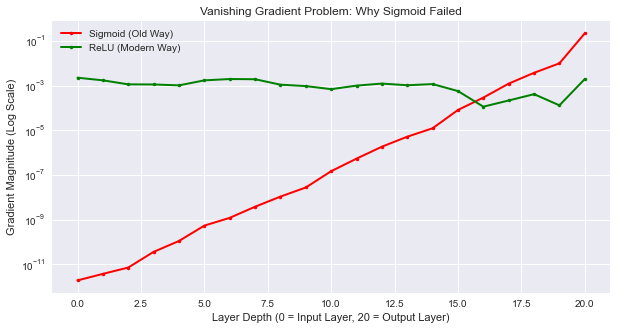

In [81]:
# Cleaner, Intuitive Implementation with Comments

class DeepMLP(nn.Module):
    def __init__(self, activation_fn, depth=30):
        super().__init__()
        # 1. Initialize an empty list to hold our layers
        layers = []
        
        # 2. Loop 'depth' times to stack layers
        for _ in range(depth):
            # Add a Linear transformation (10 inputs -> 10 outputs)
            layer = nn.Linear(10, 10)
            # 2. Apply He initialization explicitly using kaiming_uniform_
            # 'relu' is the default nonlinearity, and 'fan_in' is the default mode
            torch.nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')

            # Optional: Initialize biases to zero, which is a common practice
            if layer.bias is not None:
                torch.nn.init.constant_(layer.bias, 0)
            
            layers.append(layer)

            
            # Add the chosen Activation Function (e.g., Sigmoid() or ReLU())
            # This introduces non-linearity.
            layers.append(activation_fn()) 
        
        # 3. Add the final output layer (10 inputs -> 1 output)
        layers.append(nn.Linear(10, 1))
        
        # 4. Pack the list into nn.Sequential
        # The '*' operator unpacks the list so nn.Sequential reads it as separate arguments.
        # This creates the full pipeline automatically.
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        # Pass input x through the entire sequence of layers
        return self.net(x)

def inspect_gradients(model_class, name, color):
    # 1. Create Model & Fake Data
    model = model_class()
    inputs = torch.randn(32, 10) # Batch of 32 random vectors
    targets = torch.randn(32, 1) # Batch of 32 random targets
    
    # 2. Run Forward Pass
    outputs = model(inputs)
    loss = nn.MSELoss()(outputs, targets)
    
    # 3. Run Backward Pass (Compute Gradients)
    # This populates the .grad attribute for every weight in the network
    loss.backward()
    
    # 4. Collect Gradients for Visualization
    grads = []
    # Iterate through all parameters (weights and biases) in the model
    for name_param, param in model.named_parameters():
        # We filter for 'weight' parameters that have a valid gradient
        if "weight" in name_param and param.grad is not None:
            # Calculate the average absolute strength of the gradient for this layer
            # .abs() makes negatives positive
            # .mean() takes the average of all connections in that layer
            # .item() converts the single-value Tensor to a standard Python float
            grad_magnitude = param.grad.abs().mean().item()
            grads.append(grad_magnitude)
            
    # 5. Plot the result
    # x-axis = Layer Depth, y-axis = Gradient Magnitude
    plt.plot(grads, label=name, color=color, marker='.', linewidth=2)

plt.figure(figsize=(10, 5))
inspect_gradients(lambda: DeepMLP(nn.Sigmoid, depth=20), "Sigmoid (Old Way)", "red")
inspect_gradients(lambda: DeepMLP(nn.ReLU, depth=20), "ReLU (Modern Way)", "green")

plt.yscale('log') # IMPORTANT: Use Log scale because Sigmoid gradients get TINY
plt.title("Vanishing Gradient Problem: Why Sigmoid Failed")
plt.xlabel("Layer Depth (0 = Input Layer, 20 = Output Layer)")
plt.ylabel("Gradient Magnitude (Log Scale)")
plt.legend()
plt.show()

---
### Part 4: Application - Implicit Neural Representations (NeRF Concept)

**Recall Slide 38:** "Functions as Data". 
Instead of processing an image, can we train an MLP to *be* the image? 

Mapping: $(x, y) \to (r, g, b)$

However, standard MLPs are biased towards low-frequency signals (spectral bias). They result in blurry images. We use **Fourier Features** (mapping inputs to high-freq sines/cosines) to fix this.

In [ ]:
# --- 1. Create HARDER Synthetic Data (High Frequency) ---
def get_image():
    H, W = 100, 100
    coords = np.zeros((H, W, 2))
    image = np.zeros((H, W, 3))
    
    for i in range(H):
        for j in range(W):
            x, y = i/H, j/W
            coords[i, j] = [x, y]
            
            # Complex Pattern: Checkerboard + High Freq Sine Waves
            # This is hard for standard MLPs because it changes rapidly
            val = np.sin(20 * np.pi * x) * np.cos(20 * np.pi * y)
            val = (val + 1) / 2 # Normalize 0-1
            
            # Add a sharp edge (Circle) on top
            if (x-0.5)**2 + (y-0.5)**2 < 0.1:
                val = 1.0 - val 

            image[i, j] = [val, val, val] # Black and white for contrast
            
    return coords, image, H, W

coords, image_gt, H, W = get_image()

X_train = torch.tensor(coords.reshape(-1, 2), dtype=torch.float32).to(device)
y_train = torch.tensor(image_gt.reshape(-1, 3), dtype=torch.float32).to(device)

# --- 2. Define Model ---
class NeRF_MLP(nn.Module):
    def __init__(self, scale=10.0, use_fourier=False):
        super().__init__()
        self.use_fourier = use_fourier
        input_dim = 2
        
        if use_fourier:
            # Mapping Size: Higher mapping_size = higher capacity for detail
            self.mapping_size = 128 
            self.B = torch.randn(2, self.mapping_size).to(device) * scale
            input_dim = self.mapping_size * 2
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, 3), nn.Sigmoid()
        )

    def forward(self, x):
        if self.use_fourier:
            x_proj = 2 * np.pi * x @ self.B
            x = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
        return self.net(x)

# --- 3. Training Function ---
def train_model(model, steps=1000):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()
    psnr_history = []
    
    for i in range(steps):
        optimizer.zero_grad()
        output = model(X_train)
        loss = loss_fn(output, y_train)
        loss.backward()
        optimizer.step()
        
        # Calculate PSNR: -10 * log10(MSE)
        psnr = -10 * np.log10(loss.item())
        psnr_history.append(psnr)
        
    return model, psnr_history

# --- 4. Run Experiment ---
print("Training Standard MLP...")
model_std, psnr_std = train_model(NeRF_MLP(use_fourier=False))

print("Training Fourier MLP (Scale=10)...")
model_four, psnr_four = train_model(NeRF_MLP(use_fourier=True, scale=10.0))

# --- 5. Advanced Visualization ---
with torch.no_grad():
    pred_std = model_std(X_train).cpu().reshape(H, W, 3).numpy()
    pred_four = model_four(X_train).cpu().reshape(H, W, 3).numpy()

# Calculate Difference Maps (Absolute Error)
diff_std = np.abs(image_gt - pred_std).mean(axis=2)
diff_four = np.abs(image_gt - pred_four).mean(axis=2)

# Create 2x3 Plot
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# Row 1: Images
axs[0, 0].imshow(image_gt, cmap='gray')
axs[0, 0].set_title("Ground Truth (High Freq)")
axs[0, 1].imshow(pred_std, cmap='gray')
axs[0, 1].set_title(f"Standard MLP\nFinal PSNR: {psnr_std[-1]:.2f} dB")
axs[0, 2].imshow(pred_four, cmap='gray')
axs[0, 2].set_title(f"Fourier MLP\nFinal PSNR: {psnr_four[-1]:.2f} dB")

# Row 2: Error Analysis
# We use the same vmin/vmax to make the comparison fair!
axs[1, 0].plot(psnr_std, label="Standard")
axs[1, 0].plot(psnr_four, label="Fourier")
axs[1, 0].set_xlabel("Steps"); axs[1, 0].set_ylabel("PSNR (dB)"); axs[1, 0].legend()
axs[1, 0].set_title("PSNR Learning Curve")

im1 = axs[1, 1].imshow(diff_std, cmap='inferno', vmin=0, vmax=0.5)
axs[1, 1].set_title("Standard Error Map\n(Fails at edges)")
plt.colorbar(im1, ax=axs[1, 1], fraction=0.046)

im2 = axs[1, 2].imshow(diff_four, cmap='inferno', vmin=0, vmax=0.5)
axs[1, 2].set_title("Fourier Error Map\n(Clean)")
plt.colorbar(im2, ax=axs[1, 2], fraction=0.046)

for ax in axs.flatten():
    if not ax.has_data(): continue # Skip plot axes
    ax.axis('off') if ax != axs[1, 0] else None # Keep axes for graph

plt.tight_layout()
plt.show()

---
### Part 5: Feature Visualization (Opening the Black Box)

**Recall Slide 49-51:** "What can we optimize? Inputs!"
Instead of updating weights $\theta$, we can update the image $x$ to maximize the activation of a specific layer or class.

To make this realistic, we will first **train a CNN on MNIST** (Handwritten Digits). Then, we will ask the network: *"What does a digit '0' look like to you?"*

In [102]:
# --- 1. Load and Preprocess Data ---

# Define the transformation pipeline:
# 1. ToTensor(): Converts images (0-255) to PyTorch Tensors (0.0-1.0) and moves channel first.
# 2. Normalize((mean,), (std,)): Standardizes data. The values 0.1307 and 0.3081 
#    are the global mean and std dev of the MNIST dataset. This helps the network converge faster.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and load Training Data
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
# Download and load Test Data (to check how well the model generalizes)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

# DataLoaders handle batching (grouping images) and shuffling
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


In [103]:
# --- 2. Define the Neural Network Architecture ---
class MnistCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # Layer 1: Convolution
            # Input: 1 channel (grayscale), Output: 16 feature maps
            # Kernel: 3x3, Stride: 1 (moves 1 pixel at a time)
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1), 
            nn.ReLU(), # Activation function (removes negative values)
            
            # Layer 2: Convolution
            # Input: 16 channels, Output: 32 feature maps
            nn.Conv2d(16, 32, 3, 1), 
            nn.ReLU(),
            
            # Layer 3: Max Pooling
            # Reduces image size by half (2x2 window). 
            # This makes the model translation invariant and reduces parameters.
            nn.MaxPool2d(kernel_size=2),
            
            # Flatten: Converts 2D feature maps into a 1D vector for the Dense layers
            nn.Flatten(),
            
            # Layer 4: Fully Connected (Dense) Layer
            # Why 4608? 
            # Original image: 28x28
            # After Conv1 (no padding, 3x3 kernel): 26x26
            # After Conv2 (no padding, 3x3 kernel): 24x24
            # After MaxPool (2x2): 12x12
            # Final volume: 32 channels * 12 * 12 = 4608 pixels
            nn.Linear(4608, 128), 
            nn.ReLU(),
            
            # Output Layer: 10 neurons (one for each digit 0-9)
            nn.Linear(128, 10) 
        )

    def forward(self, x):
        # Defines how data flows through the network
        return self.net(x)

In [104]:
# Initialize Model
model = MnistCNN().to(device)

# Optimizer: Updates weights based on gradients (Adam is a standard, efficient choice)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Loss Function: CrossEntropy combines Softmax (probability) and NLLLoss (error calc)
criterion = nn.CrossEntropyLoss()

# --- 3. Training Loop ---
train_losses = []
test_accuracies = []
epochs = 3 
log_interval = 100  # Print every 100 batches

print("Starting training...")

for epoch in range(epochs):
    model.train() # Set model to training mode (enables Dropout/BatchNorm if used)
    
    # Iterate over batches of data
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to GPU if available
        data, target = data.to(device), target.to(device)
        
        # 1. Clear previous gradients (crucial step! PyTorch accumulates by default)
        optimizer.zero_grad()
        
        # 2. Forward pass: Compute predictions
        output = model(data)
        
        # 3. Compute loss: Compare predictions vs actual labels
        loss = criterion(output, target)
        
        # 4. Backward pass: Calculate gradients (how much to change weights)
        loss.backward()
        
        # 5. Optimization step: Update weights
        optimizer.step()
        
        # Record loss for plotting
        train_losses.append(loss.item())
        # --- PRINTING LOGIC HERE ---
        if batch_idx % log_interval == 0:
            # Calculate how many images have been processed
            processed = batch_idx * len(data)
            total_images = len(train_loader.dataset)
            percent = 100. * batch_idx / len(train_loader)
            
            print(f"Train Epoch: {epoch+1} [{processed}/{total_images} ({percent:.0f}%)]\tLoss: {loss.item():.6f}")
            
        
    # --- 4. Evaluation Loop (Run after every epoch) ---
    model.eval() # Set to evaluation mode
    correct = 0
    total = 0
    
    # torch.no_grad() saves memory and computation since we don't need gradients for testing
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # Get the index of the highest probability (the predicted digit)
            pred = output.argmax(dim=1, keepdim=True) 
            
            # Compare prediction to target
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    
    acc = 100. * correct / total
    test_accuracies.append(acc)
    print(f"Epoch {epoch+1}/{epochs} completed. Test Accuracy: {acc:.2f}%")

print("Training Complete.")

Starting training...
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.319583
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.270213
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.246644
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.067891
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.046527
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.064208
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.143689
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.117464
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.087818
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.038057
Epoch 1/3 completed. Test Accuracy: 98.54%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.113027
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.025215
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.016669
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.032474
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.112454
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.075137
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.005653
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.035327
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.03368

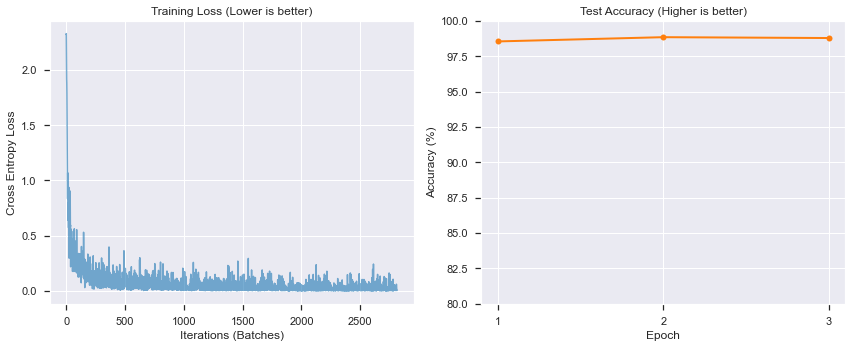

In [105]:

# --- 5. Visualization ---
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Training Loss
axs[0].plot(train_losses, label='Batch Loss', color='tab:blue', alpha=0.6)
axs[0].set_title("Training Loss (Lower is better)")
axs[0].set_xlabel("Iterations (Batches)")
axs[0].set_ylabel("Cross Entropy Loss")
axs[0].grid(True)

# Plot Test Accuracy
axs[1].plot(range(1, epochs+1), test_accuracies, marker='o', color='tab:orange', linewidth=2)
axs[1].set_title("Test Accuracy (Higher is better)")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy (%)")
axs[1].set_xticks(range(1, epochs+1))
axs[1].set_ylim(80, 100)
axs[1].grid(True)

plt.tight_layout()
plt.show()

#### Visualizing Class Preferences (Deep Dream)

Now we freeze the model weights. We start with a random noise image and use **Gradient Ascent** to modify the pixels so that the score for a specific digit (e.g., "8") increases.

Dreaming of digits and capturing history...


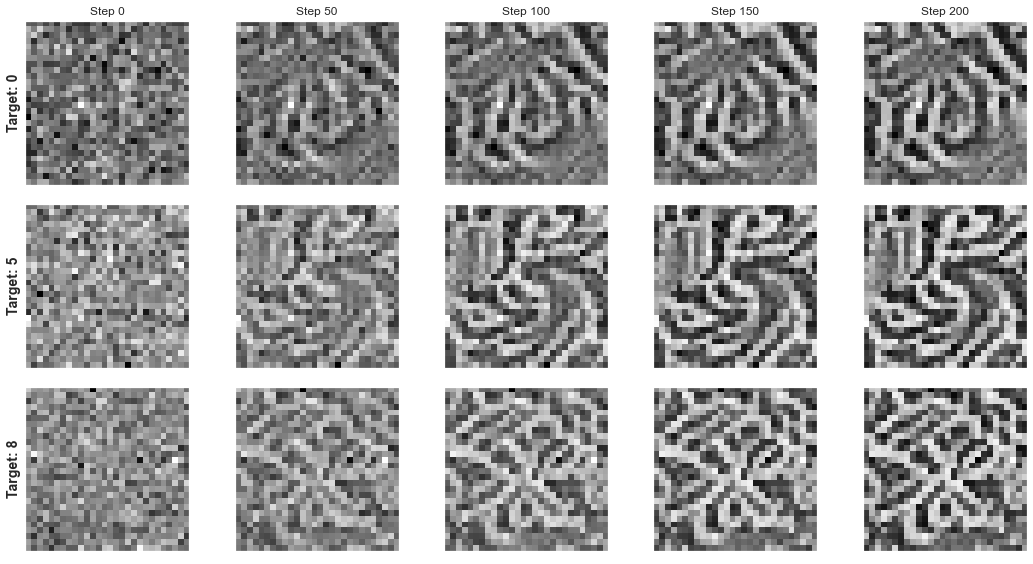

In [106]:
def dream_digit_evolution(target_digit, steps=200, snapshot_interval=50):
    model.eval()
    # Start with random noise
    img = torch.randn(1, 1, 28, 28, device=device, requires_grad=True)
    opt_img = optim.Adam([img], lr=0.03)
    
    snapshots = []
    
    for step in range(steps + 1):
        # Capture the image at the specified interval
        if step % snapshot_interval == 0:
            # We clone and detach to save the state at this exact moment
            snapshots.append((step, img.detach().cpu().squeeze().numpy().copy()))
        
        # Optimization step (skip on the very last iteration to avoid unnecessary compute)
        if step < steps:
            opt_img.zero_grad()
            output = model(img)
            # Maximize score for target digit
            loss = -output[0, target_digit]
            loss.backward()
            opt_img.step()
            
    return snapshots

# --- Visualization Setup ---
print("Dreaming of digits and capturing history...")
targets = [0, 5, 8]
steps = 200
interval = 50

# Calculate number of columns based on steps and interval
num_snapshots = (steps // interval) + 1 

fig, axs = plt.subplots(len(targets), num_snapshots, figsize=(15, 8))

for row, t in enumerate(targets):
    # Get the history of images for this digit
    history = dream_digit_evolution(t, steps=steps, snapshot_interval=interval)
    
    for col, (step_num, img_data) in enumerate(history):
        ax = axs[row, col]
        ax.imshow(img_data, cmap='gray')
        
        # Labeling
        if row == 0:
            ax.set_title(f"Step {step_num}", fontsize=12)
        if col == 0:
            ax.set_ylabel(f"Target: {t}", fontsize=14, fontweight='bold')
            
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

✅ **Conclusion:** 
The images above are **not** from the dataset. They are what the network "hallucinates" when asked to produce a specific digit. 

You might see ghostly outlines of curves for '0' or loops for '8'. This technique helps us understand what features the model is actually looking for (Class Visualization).